In [63]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [64]:
'''
Fct de conversion théorique 
'''

def conversion_theorical(input_sr355, coef=5.3):
    print('Theorical coef:', coef)
    print('Shape of sr355 input:', input_sr355.shape)
    output_array532 = coef * input_sr355
    print('Shape of sr532 output', output_array532.shape)
    return output_array532

In [65]:
class conditions:
    def __init__(self, value: float, close: str, id_where):
        self.value = value
        self.close = close 
        self.where = id_where
#         return self
    

In [66]:
import numpy.ma as ma  
class dataset:
    def __init__(self, calibrated_variable: str, simulated_variable: str, 
                 flag_variable: str, flag_value_valid: int, limite_altitude: float):
        self.calibrated_variable = calibrated_variable
        self.simulated_variable = simulated_variable
        self.flag_variable = flag_variable
        self.flag_value_valid = flag_value_valid
        self.limite_altitude = limite_altitude

#------------------------------------------

'''
Fct de récupération des données (1 profil, 1 dataset) et 
sélection en fonction de condition (input by user)
'''
class get_file:
    def get_closed_data(input_data, value, close):
        if close == 'left':                
            output_data = ma.masked_where((input_data > 0) & (input_data < value), input_data)
            output_data = output_data.filled(fill_value=np.nan)
            id_where = np.where(input_data > value)
            print(id_where)
        elif close == 'right':
            output_data = ma.masked_where(input_data > value, input_data)
            output_data = output_data.filled(fill_value=np.nan)   
            id_where = np.where(input_data < value)
            print(id_where)
        elif close == 'both':
            print()
            id_where = []
        elif (close is None):
            output_data = input_data
            id_where = []
        return output_data, id_where


    def set_dataset_with_condition(input_data, condition=None, return_index=False):   

        print('Shape of input:', input_data.shape)    
        print('Conditions for apply: ', condition.value, condition.close, condition.where)
        #------------------------
        if (condition.where is not None):
            print('1')
            id_where = condition.where
            data_where = input_data[id_where]
            output_data, _ = get_file.get_closed_data(data_where, condition.value, condition.close)            
        else: 
            print('2')
            output_data, id_where = get_file.get_closed_data(input_data, condition.value, condition.close)
             
        #------------------------    
        print('Shape of output after apply conditions:', output_data.shape)
        if (return_index):
            return output_data, id_where
        else:
            return output_data


    def get_file_dataset(mainfile, characters, wavelength, conditionf=None, return_index = False):
        '''
        dataset should be the same format: 
            - netCDF
            - variable: calibrated, simulated, flags
        '''
        input_data = xr.open_dataset(mainfile)
        limites_range = input_data['range'][input_data['range'] < characters.limite_altitude]
        sr_data = input_data[characters.calibrated_variable].sel(wavelength=wavelength, range=limites_range)/input_data[characters.simulated_variable].sel(wavelength=wavelength, range=limites_range)
        flagged_data = sr_data.where(input_data[characters.flag_variable].sel(wavelength=wavelength)==characters.flag_value_valid, drop=False)
        output_data = flagged_data.resample(time = '15min', skipna=True).mean('time')
        # print('get_file_dataset', conditionf.where)
        final_output_data = get_file.set_dataset_with_condition(output_data, conditionf, return_index = False)          
        return final_output_data



    def get_folder_dataset(mainfolder: str, patternfile: str, characters, wavelength, 
                           grouped=False, conditionF=None, return_index=False):
        from tqdm import tqdm
        listfiles = sorted(Path(mainfolder).glob(patternfile))
        outputs_data = []
        if grouped:
            for file in tqdm(listfiles):
                print(file)          
                output_1_data = get_file.get_file_dataset(file, characters, wavelength, conditions(np.nan, None, None), False)
                outputs_data.append(output_1_data)
        
            grouped_outputs_data = np.concatenate(outputs_data, axis=0)

            # check y_shape of grouped output data
            #-----------------------------------    
            if (output_1_data.shape[1] == grouped_outputs_data.shape[1]):
                print('Shape of output data after groupping', grouped_outputs_data.shape)
                print('------------Groupping: Done-------------')
                # return grouped_outputs_data
            else:
                print('------------Groupping: Error-------------')
                print('Shape of 1 output:', output_1_data.shape)
                print('Shape of list outputs:', outputs_data.shape)
                return 0
        else:
            for file in tqdm(listfiles):
                print(file)    
                print('before', conditionF.where)        
                output_1_data = get_file.get_file_dataset(file, characters, wavelength, None, True)
                print('after', conditionF.where)
                outputs_data.append(output_1_data)

            grouped_outputs_data = outputs_data
            print('Shape of output data without groupping', grouped_outputs_data.shape)
            print('------------Groupping: Done-------------')

        final_output_data, ids_where = get_file.set_dataset_with_condition(grouped_outputs_data, conditionF, return_index=True)
        print('Shape of output data after setting conditions', final_output_data.shape)
        print('------------Setting: Done-------------')
        return final_output_data, ids_where

In [67]:
ipral_characters = dataset('calibrated', 'simulated', 'flags', 0, 20000)

#---------------------
dataset_name = 'IPRAL2020'
maindir = '/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/'
pattern = 'ipral_1a_Lz1R15mF30sPbck_v01_2020*_000000_1440.nc'
#---------------------

# THEORICAL METHOD
method_name = 'THEORICAL'

print(f'----------------GENERATE DATA--------------------')
condt = conditions('None', 'None', None)
print('----355')


----------------GENERATE DATA--------------------
----355


In [6]:
dataset355, ids = get_file.get_folder_dataset(maindir, pattern, ipral_characters, 355, grouped=True, conditionF=condt, return_index=True)
# print(ids)


  0%|          | 0/79 [00:00<?, ?it/s]

/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200106_000000_1440.nc


  1%|▏         | 1/79 [00:00<00:27,  2.80it/s]

Shape of input: (24, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (24, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200116_000000_1440.nc


  3%|▎         | 2/79 [00:00<00:31,  2.46it/s]

Shape of input: (30, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (30, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200120_000000_1440.nc


  4%|▍         | 3/79 [00:01<00:30,  2.50it/s]

Shape of input: (24, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (24, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200121_000000_1440.nc


  5%|▌         | 4/79 [00:01<00:30,  2.46it/s]

Shape of input: (28, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (28, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200122_000000_1440.nc


  6%|▋         | 5/79 [00:02<00:29,  2.52it/s]

Shape of input: (19, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (19, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200123_000000_1440.nc


  8%|▊         | 6/79 [00:02<00:28,  2.57it/s]

Shape of input: (24, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (24, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200124_000000_1440.nc


  9%|▉         | 7/79 [00:02<00:26,  2.73it/s]

Shape of input: (20, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (20, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200206_000000_1440.nc


 10%|█         | 8/79 [00:03<00:32,  2.17it/s]

Shape of input: (57, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (57, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200207_000000_1440.nc


 11%|█▏        | 9/79 [00:04<00:36,  1.92it/s]

Shape of input: (67, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (67, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200212_000000_1440.nc


 13%|█▎        | 10/79 [00:04<00:32,  2.15it/s]

Shape of input: (21, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (21, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200218_000000_1440.nc


 14%|█▍        | 11/79 [00:04<00:29,  2.33it/s]

Shape of input: (23, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (23, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200221_000000_1440.nc


 15%|█▌        | 12/79 [00:05<00:30,  2.21it/s]

Shape of input: (30, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (30, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200326_000000_1440.nc


 16%|█▋        | 13/79 [00:05<00:27,  2.36it/s]

Shape of input: (20, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (20, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200401_000000_1440.nc


 18%|█▊        | 14/79 [00:06<00:31,  2.04it/s]

Shape of input: (60, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (60, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200402_000000_1440.nc


 19%|█▉        | 15/79 [00:07<00:36,  1.76it/s]

Shape of input: (48, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (48, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200415_000000_1440.nc


 20%|██        | 16/79 [00:07<00:32,  1.93it/s]

Shape of input: (37, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (37, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200416_000000_1440.nc


 22%|██▏       | 17/79 [00:08<00:33,  1.83it/s]

Shape of input: (60, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (60, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200423_000000_1440.nc


 23%|██▎       | 18/79 [00:08<00:32,  1.86it/s]

Shape of input: (38, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (38, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200424_000000_1440.nc


 24%|██▍       | 19/79 [00:09<00:33,  1.79it/s]

Shape of input: (52, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (52, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200507_000000_1440.nc


 25%|██▌       | 20/79 [00:09<00:32,  1.81it/s]

Shape of input: (38, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (38, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200513_000000_1440.nc


 27%|██▋       | 21/79 [00:10<00:32,  1.78it/s]

Shape of input: (54, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (54, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200514_000000_1440.nc


 28%|██▊       | 22/79 [00:11<00:39,  1.44it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200515_000000_1440.nc


 29%|██▉       | 23/79 [00:12<00:40,  1.38it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200516_000000_1440.nc


 30%|███       | 24/79 [00:12<00:41,  1.32it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200517_000000_1440.nc


 32%|███▏      | 25/79 [00:13<00:45,  1.19it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200518_000000_1440.nc


 33%|███▎      | 26/79 [00:14<00:45,  1.15it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200519_000000_1440.nc


 34%|███▍      | 27/79 [00:15<00:46,  1.12it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200520_000000_1440.nc


 35%|███▌      | 28/79 [00:16<00:43,  1.17it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200521_000000_1440.nc


 37%|███▋      | 29/79 [00:17<00:42,  1.18it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200522_000000_1440.nc


 38%|███▊      | 30/79 [00:18<00:37,  1.30it/s]

Shape of input: (32, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (32, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200526_000000_1440.nc


 39%|███▉      | 31/79 [00:18<00:34,  1.37it/s]

Shape of input: (53, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (53, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200527_000000_1440.nc


 41%|████      | 32/79 [00:19<00:36,  1.29it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200528_000000_1440.nc


 42%|████▏     | 33/79 [00:20<00:36,  1.27it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200529_000000_1440.nc


 43%|████▎     | 34/79 [00:21<00:37,  1.20it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200530_000000_1440.nc


 44%|████▍     | 35/79 [00:21<00:32,  1.36it/s]

Shape of input: (41, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (41, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200603_000000_1440.nc


 46%|████▌     | 36/79 [00:22<00:26,  1.62it/s]

Shape of input: (19, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (19, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200622_000000_1440.nc


 47%|████▋     | 37/79 [00:22<00:27,  1.55it/s]

Shape of input: (62, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (62, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200623_000000_1440.nc


 48%|████▊     | 38/79 [00:23<00:30,  1.35it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200624_000000_1440.nc


 49%|████▉     | 39/79 [00:24<00:30,  1.31it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200625_000000_1440.nc


 51%|█████     | 40/79 [00:25<00:29,  1.34it/s]

Shape of input: (79, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (79, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200708_000000_1440.nc


 52%|█████▏    | 41/79 [00:25<00:27,  1.39it/s]

Shape of input: (51, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (51, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200709_000000_1440.nc


 53%|█████▎    | 42/79 [00:26<00:26,  1.38it/s]

Shape of input: (95, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (95, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200728_000000_1440.nc


 54%|█████▍    | 43/79 [00:27<00:24,  1.46it/s]

Shape of input: (50, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (50, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200729_000000_1440.nc


 56%|█████▌    | 44/79 [00:28<00:26,  1.33it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200730_000000_1440.nc


 57%|█████▋    | 45/79 [00:29<00:29,  1.16it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200731_000000_1440.nc


 58%|█████▊    | 46/79 [00:29<00:25,  1.28it/s]

Shape of input: (53, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (53, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200805_000000_1440.nc


 59%|█████▉    | 47/79 [00:30<00:23,  1.38it/s]

Shape of input: (54, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (54, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200807_000000_1440.nc


 61%|██████    | 48/79 [00:31<00:23,  1.31it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200808_000000_1440.nc


 62%|██████▏   | 49/79 [00:31<00:20,  1.49it/s]

Shape of input: (41, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (41, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200831_000000_1440.nc


 63%|██████▎   | 50/79 [00:32<00:16,  1.74it/s]

Shape of input: (19, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (19, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200901_000000_1440.nc


 65%|██████▍   | 51/79 [00:32<00:13,  2.02it/s]

Shape of input: (22, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (22, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200902_000000_1440.nc


 66%|██████▌   | 52/79 [00:32<00:12,  2.14it/s]

Shape of input: (30, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (30, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200903_000000_1440.nc


 67%|██████▋   | 53/79 [00:33<00:13,  1.97it/s]

Shape of input: (58, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (58, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200904_000000_1440.nc


 68%|██████▊   | 54/79 [00:34<00:15,  1.57it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200905_000000_1440.nc


 70%|██████▉   | 55/79 [00:34<00:13,  1.75it/s]

Shape of input: (31, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (31, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200907_000000_1440.nc


 71%|███████   | 56/79 [00:35<00:13,  1.75it/s]

Shape of input: (56, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (56, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200908_000000_1440.nc


 72%|███████▏  | 57/79 [00:35<00:11,  1.88it/s]

Shape of input: (28, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (28, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200911_000000_1440.nc


 73%|███████▎  | 58/79 [00:36<00:11,  1.90it/s]

Shape of input: (58, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (58, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200912_000000_1440.nc


 75%|███████▍  | 59/79 [00:37<00:12,  1.61it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200913_000000_1440.nc


 76%|███████▌  | 60/79 [00:38<00:12,  1.46it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200914_000000_1440.nc


 77%|███████▋  | 61/79 [00:38<00:13,  1.38it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200915_000000_1440.nc


 78%|███████▊  | 62/79 [00:39<00:12,  1.32it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200916_000000_1440.nc


 80%|███████▉  | 63/79 [00:40<00:12,  1.27it/s]

Shape of input: (69, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (69, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200918_000000_1440.nc


 81%|████████  | 64/79 [00:41<00:11,  1.35it/s]

Shape of input: (44, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (44, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200921_000000_1440.nc


 82%|████████▏ | 65/79 [00:41<00:09,  1.42it/s]

Shape of input: (53, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (53, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200922_000000_1440.nc


 84%|████████▎ | 66/79 [00:42<00:10,  1.29it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200923_000000_1440.nc


 85%|████████▍ | 67/79 [00:43<00:07,  1.52it/s]

Shape of input: (28, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (28, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201012_000000_1440.nc


 86%|████████▌ | 68/79 [00:43<00:06,  1.74it/s]

Shape of input: (14, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (14, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201019_000000_1440.nc


 87%|████████▋ | 69/79 [00:44<00:05,  1.69it/s]

Shape of input: (53, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (53, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201104_000000_1440.nc


 89%|████████▊ | 70/79 [00:44<00:05,  1.59it/s]

Shape of input: (53, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (53, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201105_000000_1440.nc


 90%|████████▉ | 71/79 [00:45<00:05,  1.35it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201106_000000_1440.nc


 91%|█████████ | 72/79 [00:46<00:05,  1.26it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201107_000000_1440.nc


 92%|█████████▏| 73/79 [00:48<00:05,  1.04it/s]

Shape of input: (87, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (87, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201117_000000_1440.nc
Shape of input: (1, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (1, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201126_000000_1440.nc


 95%|█████████▍| 75/79 [00:48<00:03,  1.27it/s]

Shape of input: (47, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (47, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201127_000000_1440.nc


 96%|█████████▌| 76/79 [00:49<00:02,  1.40it/s]

Shape of input: (39, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (39, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201128_000000_1440.nc


 97%|█████████▋| 77/79 [00:50<00:01,  1.32it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201129_000000_1440.nc


 99%|█████████▊| 78/79 [00:50<00:00,  1.41it/s]

Shape of input: (39, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (39, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201218_000000_1440.nc


100%|██████████| 79/79 [00:51<00:00,  1.54it/s]

Shape of input: (6, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (6, 1333)
Shape of output data after groupping (4664, 1333)
------------Groupping: Done-------------
Shape of input: (4664, 1333)
Conditions for apply:  1.0 left None
2


(array([   0,    0,    0, ..., 4663, 4663, 4663]), array([   8,    9,   10, ..., 1317, 1321, 1327]))
Shape of output after apply conditions: (4664, 1333)
Shape of output data after setting conditions (4664, 1333)
------------Setting: Done-------------


In [8]:
# saving
import pickle
home_dir = '/homedata/nmpnguyen/comparaison/'
# dataset355 = dataset355[ids]
with open(Path(home_dir,f'{dataset_name}-355-mes_{method_name}_CONDT-SR355-{condt.value}-{condt.close}.pkl'), 'wb') as output_dataset:
    pickle.dump(dataset355, output_dataset)  

In [9]:
dataset355#.shape, dataset355[ids]

array([[        nan,         nan,         nan, ..., -6.97531339,
        -3.28296589, -8.03560083],
       [        nan,         nan,         nan, ..., -1.59497475,
        -4.37333816,         nan],
       [        nan,         nan,         nan, ..., -0.85597418,
        -1.50573299, -1.11412318],
       ...,
       [        nan,         nan,         nan, ..., -0.50531799,
        -0.47467166,         nan],
       [        nan,         nan,         nan, ..., -0.4010056 ,
        -0.63744809, -0.7479318 ],
       [        nan,         nan,         nan, ...,         nan,
                nan, -3.35464466]])

In [10]:
condt2 = conditions(1.0, 'right', ids)
print('----532')
dataset532mes = get_file.get_folder_dataset(maindir, pattern, ipral_characters, 532, True, condt2, False)

  0%|          | 0/79 [00:00<?, ?it/s]

----532
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200106_000000_1440.nc


  1%|▏         | 1/79 [00:00<00:15,  4.90it/s]

Shape of input: (24, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (24, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200116_000000_1440.nc


  3%|▎         | 2/79 [00:00<00:20,  3.67it/s]

Shape of input: (30, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (30, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200120_000000_1440.nc


  4%|▍         | 3/79 [00:00<00:22,  3.39it/s]

Shape of input: (24, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (24, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200121_000000_1440.nc


  5%|▌         | 4/79 [00:01<00:29,  2.50it/s]

Shape of input: (28, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (28, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200122_000000_1440.nc


  6%|▋         | 5/79 [00:01<00:27,  2.72it/s]

Shape of input: (19, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (19, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200123_000000_1440.nc


  8%|▊         | 6/79 [00:02<00:24,  2.98it/s]

Shape of input: (24, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (24, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200124_000000_1440.nc


  9%|▉         | 7/79 [00:02<00:22,  3.19it/s]

Shape of input: (20, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (20, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200206_000000_1440.nc


 10%|█         | 8/79 [00:03<00:37,  1.91it/s]

Shape of input: (57, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (57, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200207_000000_1440.nc


 11%|█▏        | 9/79 [00:04<00:37,  1.85it/s]

Shape of input: (67, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (67, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200212_000000_1440.nc


 13%|█▎        | 10/79 [00:04<00:31,  2.23it/s]

Shape of input: (21, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (21, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200218_000000_1440.nc


 14%|█▍        | 11/79 [00:04<00:29,  2.27it/s]

Shape of input: (23, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (23, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200221_000000_1440.nc


 15%|█▌        | 12/79 [00:05<00:34,  1.93it/s]

Shape of input: (30, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (30, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200326_000000_1440.nc


 16%|█▋        | 13/79 [00:05<00:35,  1.87it/s]

Shape of input: (20, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (20, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200401_000000_1440.nc


 18%|█▊        | 14/79 [00:06<00:39,  1.63it/s]

Shape of input: (60, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (60, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200402_000000_1440.nc


 19%|█▉        | 15/79 [00:07<00:39,  1.61it/s]

Shape of input: (48, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (48, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200415_000000_1440.nc


 20%|██        | 16/79 [00:07<00:36,  1.74it/s]

Shape of input: (37, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (37, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200416_000000_1440.nc


 22%|██▏       | 17/79 [00:08<00:34,  1.79it/s]

Shape of input: (60, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (60, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200423_000000_1440.nc


 23%|██▎       | 18/79 [00:09<00:38,  1.60it/s]

Shape of input: (38, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (38, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200424_000000_1440.nc


 24%|██▍       | 19/79 [00:09<00:35,  1.71it/s]

Shape of input: (52, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (52, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200507_000000_1440.nc


 25%|██▌       | 20/79 [00:10<00:33,  1.74it/s]

Shape of input: (38, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (38, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200513_000000_1440.nc


 27%|██▋       | 21/79 [00:10<00:33,  1.73it/s]

Shape of input: (54, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (54, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200514_000000_1440.nc


 28%|██▊       | 22/79 [00:11<00:35,  1.62it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200515_000000_1440.nc


 29%|██▉       | 23/79 [00:13<00:52,  1.06it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200516_000000_1440.nc


 30%|███       | 24/79 [00:15<01:10,  1.28s/it]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200517_000000_1440.nc


 32%|███▏      | 25/79 [00:16<01:14,  1.37s/it]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200518_000000_1440.nc


 33%|███▎      | 26/79 [00:17<01:02,  1.19s/it]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200519_000000_1440.nc


 34%|███▍      | 27/79 [00:18<01:03,  1.23s/it]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200520_000000_1440.nc


 35%|███▌      | 28/79 [00:19<00:54,  1.07s/it]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200521_000000_1440.nc


 37%|███▋      | 29/79 [00:20<00:52,  1.05s/it]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200522_000000_1440.nc


 38%|███▊      | 30/79 [00:21<00:44,  1.11it/s]

Shape of input: (32, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (32, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200526_000000_1440.nc


 39%|███▉      | 31/79 [00:21<00:37,  1.27it/s]

Shape of input: (53, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (53, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200527_000000_1440.nc


 41%|████      | 32/79 [00:22<00:38,  1.22it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200528_000000_1440.nc


 42%|████▏     | 33/79 [00:23<00:37,  1.23it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200529_000000_1440.nc


 43%|████▎     | 34/79 [00:24<00:43,  1.03it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200530_000000_1440.nc


 46%|████▌     | 36/79 [00:26<00:33,  1.28it/s]

Shape of input: (41, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (41, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200603_000000_1440.nc
Shape of input: (19, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (19, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200622_000000_1440.nc


 47%|████▋     | 37/79 [00:26<00:33,  1.26it/s]

Shape of input: (62, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (62, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200623_000000_1440.nc


 48%|████▊     | 38/79 [00:27<00:32,  1.27it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200624_000000_1440.nc


 49%|████▉     | 39/79 [00:29<00:37,  1.07it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200625_000000_1440.nc


 51%|█████     | 40/79 [00:29<00:32,  1.22it/s]

Shape of input: (79, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (79, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200708_000000_1440.nc


 52%|█████▏    | 41/79 [00:30<00:27,  1.39it/s]

Shape of input: (51, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (51, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200709_000000_1440.nc


 53%|█████▎    | 42/79 [00:31<00:29,  1.26it/s]

Shape of input: (95, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (95, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200728_000000_1440.nc


 54%|█████▍    | 43/79 [00:31<00:25,  1.40it/s]

Shape of input: (50, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (50, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200729_000000_1440.nc


 56%|█████▌    | 44/79 [00:32<00:25,  1.36it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200730_000000_1440.nc


 57%|█████▋    | 45/79 [00:34<00:35,  1.04s/it]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200731_000000_1440.nc


 58%|█████▊    | 46/79 [00:35<00:34,  1.04s/it]

Shape of input: (53, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (53, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200805_000000_1440.nc


 59%|█████▉    | 47/79 [00:35<00:29,  1.09it/s]

Shape of input: (54, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (54, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200807_000000_1440.nc


 61%|██████    | 48/79 [00:36<00:26,  1.15it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200808_000000_1440.nc


 63%|██████▎   | 50/79 [00:37<00:16,  1.76it/s]

Shape of input: (41, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (41, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200831_000000_1440.nc
Shape of input: (19, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (19, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200901_000000_1440.nc


 65%|██████▍   | 51/79 [00:37<00:13,  2.14it/s]

Shape of input: (22, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (22, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200902_000000_1440.nc


 66%|██████▌   | 52/79 [00:37<00:12,  2.10it/s]

Shape of input: (30, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (30, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200903_000000_1440.nc


 67%|██████▋   | 53/79 [00:38<00:14,  1.75it/s]

Shape of input: (58, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (58, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200904_000000_1440.nc


 68%|██████▊   | 54/79 [00:39<00:15,  1.57it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200905_000000_1440.nc


 70%|██████▉   | 55/79 [00:39<00:13,  1.76it/s]

Shape of input: (31, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (31, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200907_000000_1440.nc


 71%|███████   | 56/79 [00:40<00:14,  1.58it/s]

Shape of input: (56, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (56, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200908_000000_1440.nc


 72%|███████▏  | 57/79 [00:40<00:11,  1.89it/s]

Shape of input: (28, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (28, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200911_000000_1440.nc


 73%|███████▎  | 58/79 [00:41<00:13,  1.52it/s]

Shape of input: (58, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (58, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200912_000000_1440.nc


 75%|███████▍  | 59/79 [00:42<00:13,  1.45it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200913_000000_1440.nc


 76%|███████▌  | 60/79 [00:43<00:13,  1.42it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200914_000000_1440.nc


 77%|███████▋  | 61/79 [00:44<00:12,  1.39it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200915_000000_1440.nc


 78%|███████▊  | 62/79 [00:44<00:12,  1.38it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200916_000000_1440.nc


 80%|███████▉  | 63/79 [00:45<00:10,  1.46it/s]

Shape of input: (69, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (69, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200918_000000_1440.nc


 81%|████████  | 64/79 [00:45<00:09,  1.56it/s]

Shape of input: (44, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (44, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200921_000000_1440.nc


 82%|████████▏ | 65/79 [00:47<00:12,  1.11it/s]

Shape of input: (53, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (53, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200922_000000_1440.nc


 84%|████████▎ | 66/79 [00:48<00:10,  1.20it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200923_000000_1440.nc


 86%|████████▌ | 68/79 [00:48<00:05,  1.88it/s]

Shape of input: (28, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (28, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201012_000000_1440.nc
Shape of input: (14, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (14, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201019_000000_1440.nc


 87%|████████▋ | 69/79 [00:49<00:05,  1.67it/s]

Shape of input: (53, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (53, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201104_000000_1440.nc


 89%|████████▊ | 70/79 [00:50<00:05,  1.64it/s]

Shape of input: (53, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (53, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201105_000000_1440.nc


 90%|████████▉ | 71/79 [00:51<00:05,  1.40it/s]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201106_000000_1440.nc


 91%|█████████ | 72/79 [00:53<00:08,  1.15s/it]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201107_000000_1440.nc


 92%|█████████▏| 73/79 [00:54<00:06,  1.16s/it]

Shape of input: (87, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (87, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201117_000000_1440.nc
Shape of input: (1, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (1, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201126_000000_1440.nc


 95%|█████████▍| 75/79 [00:54<00:03,  1.14it/s]

Shape of input: (47, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (47, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201127_000000_1440.nc


 96%|█████████▌| 76/79 [00:55<00:02,  1.06it/s]

Shape of input: (39, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (39, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201128_000000_1440.nc


 97%|█████████▋| 77/79 [00:57<00:02,  1.08s/it]

Shape of input: (97, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (97, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201129_000000_1440.nc


100%|██████████| 79/79 [00:58<00:00,  1.35it/s]

Shape of input: (39, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (39, 1333)
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201218_000000_1440.nc
Shape of input: (6, 1333)
Conditions for apply:  nan None None
2
Shape of output after apply conditions: (6, 1333)


Shape of output data after groupping (4664, 1333)
------------Groupping: Done-------------
Shape of input: (4664, 1333)
Conditions for apply:  1.0 right (array([   0,    0,    0, ..., 4663, 4663, 4663]), array([   8,    9,   10, ..., 1317, 1321, 1327]))
1
(array([      0,     190,     197, ..., 1917812, 1917813, 1917814]),)
Shape of output after apply conditions: (1917815,)
Shape of output data after setting conditions (1917815,)
------------Setting: Done-------------


In [12]:
dataset532mes[0].shape, dataset355.shape

((1917815,), (1917815,))

In [61]:
# saving
with open(Path(home_dir,f'{dataset_name}-532-mes_{method_name}_CONDT-SR355-{condt.value}-{condt.close}.pkl'), 'wb') as output_dataset:
    pickle.dump(dataset532mes[0], output_dataset)

In [13]:
dataset532pred = conversion_theorical(dataset355, 5.3)
# saving
# with open(Path(home_dir,f'{dataset_name}-532-pred_{method_name}_CONDT-SR355-{condt.value}-{condt.close}.pkl'), 'wb') as output_dataset:
#     pickle.dump(dataset532pred, output_dataset)

Theorical coef: 5.3
Shape of sr355 input: (1917815,)
Shape of sr532 output (1917815,)


In [16]:
NotNans = np.logical_and(~np.isnan(dataset532mes[0].ravel()), ~np.isnan(dataset532pred.ravel()))
# dataset532mes[0].ravel()
# dataset532mes = dataset532mes[0].ravel()[NotNans]
# dataset532pred = dataset532pred.ravel()[NotNans]

In [28]:
negative_ids = np.logical_and(dataset532mes[0].ravel()[NotNans]>0, dataset532pred.ravel()[NotNans]>0)

new_dataset532mes = dataset532mes[0].ravel()[NotNans][negative_ids]
new_dataset532pred = dataset532pred.ravel()[NotNans][negative_ids]

(array([[3.4400e+02, 6.7000e+01, 2.7000e+01, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.3300e+02, 5.6000e+01, 1.8000e+01, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.3800e+02, 6.5000e+01, 3.3000e+01, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [4.4670e+04, 5.0000e+01, 2.0000e+01, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.5303e+04, 5.4000e+01, 9.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.7607e+04, 5.2000e+01, 9.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]]),
 array([3.66738076e-05, 1.00363070e-02, 2.00359403e-02, 3.00355735e-02,
        4.00352067e-02, 5.00348400e-02, 6.00344732e-02, 7.00341064e-02,
        8.00337397e-02, 9.00333729e-02, 1.00033006e-01, 1.10032639e-01,
        1.20032273e-01, 1.30031906e-01, 1.40031539e-01, 1.50031172e-01,
        1.60030806e-01, 1.70030439e-01, 1.80030072e-01, 1.90029705e-01,
        2.00029338e-01, 2.10028972e-01, 2.2002860

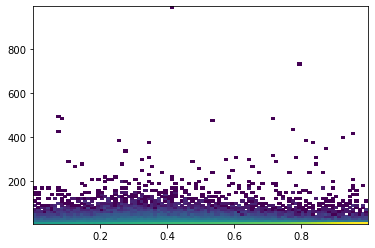

In [36]:
plt.hist2d(new_dataset532mes, new_dataset532pred, bins=100, norm=LogNorm())

In [38]:
class plots:
    '''
    Script sert à créer l'histogramme avec le colorbar représentant 
    la proprortion de la distribution des points et la ligne diagonale du plot 
    '''
    def __init__(self, method_name, dataset_name, closed_units, min_value, max_value, mesures, predictes, 
        captions, labels, output_path):
        self.method_name = method_name
        self.dataset_name = dataset_name
        self.closed_units = closed_units
        bins_array = np.arange(min_value, max_value, 0.1)
        H, self.xedges, self.yedges = np.histogram2d(mesures, predictes, bins = [bins_array, bins_array])
        self.bins_array = bins_array
        Hpercents = (H/mesures.shape[0])*100
        self.Hpercents = Hpercents
        self.labels = labels
        self.captions = captions
        self.output_path = output_path
        self.min_value = min_value
        self.max_value = max_value

    def precent_hist2d(self):
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        p = ax.pcolormesh(self.xedges, self.yedges, (self.Hpercents).T, norm=LogNorm(vmin=1e-3, vmax=1e0))
        cbar = plt.colorbar(p, ax=ax, extend='both', label='Probability, %')
        cbar.ax.tick_params(labelsize=13)
        # the diagonal line
        ax.plot(self.bins_array, self.bins_array, '-r')
        ax.plot(self.bins_array + self.closed_units[-1], self.bins_array, linestyle ='--', label = f'+/- {self.closed_units[-1]}', color = 'red')
        ax.plot(self.bins_array - self.closed_units[-1], self.bins_array, linestyle ='--', color = 'red')
        ax.legend()
        # grid
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.3)
        ax.xaxis.grid(color='gray', linestyle='dashed', alpha=0.3)
        # title
        plt.suptitle(f'{self.method_name}-{self.dataset_name}', ha='left', fontsize=16)
        # subtitle        
#         title_chains = [f'+/- {unit} : {np.round(sts, decimals=2)}% \n' for unit,sts in zip(self.closed_units, self.stats)]
#         title_chains.append(self.captions[0])
        title_chains = [self.captions]
        plt.title(" ".join(title_chains), loc='left', fontsize=11)
        # AXIS LABELS
        plt.ylabel(self.labels[1], fontsize=13)
        plt.xlabel(self.labels[0], fontsize=13)
        ax.tick_params(labelcolor='k', labelsize=13)
        # CAPTION
#         plt.text(-0.5, -10.5, self.captions[0], ha='left', fontsize = 11, alpha=0.9)

        # X-LIM & Y-LIM
        plt.xlim(self.min_value, self.max_value)
        plt.ylim(self.min_value, self.max_value)
        plt.tight_layout()
#         print(Path(self.output_path, f'{self.dataset_name}_{self.method_name}_{self.captions[1]}.png'))
#         plt.savefig(Path(self.output_path, f'{self.dataset_name}_{self.method_name}_{self.captions[1]}.png'))
#         plt.close()

In [12]:
dataset_name = 'IPRAL2020'
years = ['2018', '2019', '2020']
maindir = '/homedata/nmpnguyen/IPRAL/NETCDF/v_simple'
pattern = 'ipral_1a_Lz1R15mF30sPbck_v01_*_000000_1440.nc'
# all_sr355 = []
# all_sr532 = []
for year in years:
    for file in sorted(Path(maindir, year).glob(pattern)):
        print(file)
#         dt = xr.open_dataset(file)
#         z = (dt['range'] < 20000)

#         sr355 = (dt['calibrated']/dt['simulated']).isel(range = z, wavelength=0)
#         sr355 = sr355.where(dt['flags'].isel(wavelength=0) == 0, drop=True)   
#         sr532 = (dt['calibrated']/dt['simulated']).isel(range = z, wavelength=1)
#         sr532 = sr532.where(dt['flags'].isel(wavelength=1) == 0, drop=True)
#         if (sr355.shape[0] != 0) | (sr532.shape[0] != 0):
#             sr355 = sr355.resample(time = '15min').mean('time', skipna=True)
#             sr532 = sr532.resample(time = '15min').mean('time', skipna=True)

#         all_sr355.append(sr355)
#         all_sr532.append(sr532)

/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2018/ipral_1a_Lz1R15mF30sPbck_v01_20180221_000000_1440.nc
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2018/ipral_1a_Lz1R15mF30sPbck_v01_20180222_000000_1440.nc
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2018/ipral_1a_Lz1R15mF30sPbck_v01_20180223_000000_1440.nc
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2018/ipral_1a_Lz1R15mF30sPbck_v01_20180224_000000_1440.nc
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2018/ipral_1a_Lz1R15mF30sPbck_v01_20180225_000000_1440.nc
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2018/ipral_1a_Lz1R15mF30sPbck_v01_20180226_000000_1440.nc
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2018/ipral_1a_Lz1R15mF30sPbck_v01_20180227_000000_1440.nc
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2018/ipral_1a_Lz1R15mF30sPbck_v01_20180228_000000_1440.nc
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2018/ipral_1a_Lz1R15mF30sPbck_v01_20180314_000000_1440.nc
/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2018/ipral_1a_Lz1R15mF30sPbck_v01_20180320_000000_1440.nc


In [155]:
all_sr355 = xr.concat(all_sr355, dim='time')
all_sr532 = xr.concat(all_sr532, dim='time')

In [156]:
a0, a = np.intersect1d(all_sr355['time'], all_sr532['time'], return_indices=True)[1:]
all_sr355 = all_sr355.isel(time=a0)
all_sr532 = all_sr532.isel(time=a)

In [24]:
# pattern = ['/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr',
#           '3000-4000.nc']
pattern = ['/homedata/nmpnguyen/comparaison/IPRAL2018_IPRAL2019_IPRAL2020-', 
           'mes_THEORICAL_CONDT-None-None-None.nc']
dataset_name = 'IPRAL2018'
all_sr355 = xr.open_dataarray(f'{pattern[0]}355-{pattern[1]}')
all_sr532 = xr.open_dataarray(f'{pattern[0]}532-{pattern[1]}')

In [20]:
all_sr532.shape, all_sr355.shape

((14101, 1333), (14101, 1333))

Text(0.5, 0, '532 mesures')

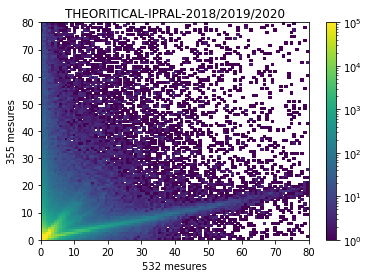

In [21]:
plt.hist2d(all_sr532.values.ravel(), all_sr355.values.ravel(), norm=LogNorm(vmax=1e5), range=[[0,80], [0,80]], bins=100, density=False)
plt.colorbar()
# plt.title('all_sr355.values.ravel(), all_sr532.values.ravel()')
plt.title('THEORITICAL-IPRAL-2018/2019/2020')
plt.ylabel('355 mesures')
plt.xlabel('532 mesures')

# params_plot = plots('THEORICAL', dataset_name, np.arange(0.01,1,0.05), 0, 50, all_sr355.values.ravel(), all_sr532.values.ravel(),
#                     f'{(~np.isnan(all_sr532.values[all_sr355.values>0])).sum()} points total', ['355 mesures', '532 mesures'], ' ')
# params_plot.precent_hist2d()


In [189]:
 all_sr355.values.ravel()*5.3

array([ 5.02294881e-06,  2.08003431e-05,  8.64133063e-03, ...,
        1.62440255e+00,  4.71854496e-01, -1.77796167e+01])

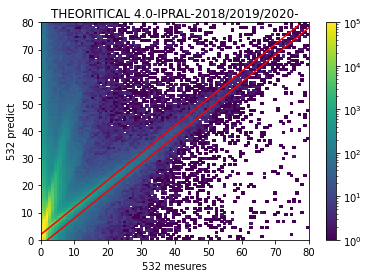

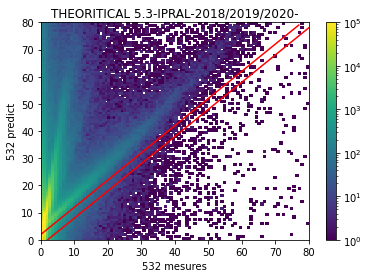

In [62]:
for const in [4.0, 5.3]: 
    fig, ax = plt.subplots()
    p = ax.hist2d(all_sr532.values.ravel(), all_sr355.values.ravel()*const, norm=LogNorm(vmax=1e5), range=[[0,80], [0,80]], bins=100, density=False)
    plt.colorbar(p[3], ax=ax)
#     ax.plot(np.arange(0,80,1), np.arange(0,80,1), color='r')
    ax.plot(np.arange(0,80,1)+2, np.arange(0,80,1), color='r')
    ax.plot(np.arange(0,80,1)-2, np.arange(0,80,1), color='r')
    # plt.title('all_sr355.values.ravel(), all_sr532.values.ravel()')
    ax.set_title(f'THEORITICAL {const}-IPRAL-2018/2019/2020-')
    ax.set_ylabel('532 predict')
    ax.set_xlabel('532 mesures')

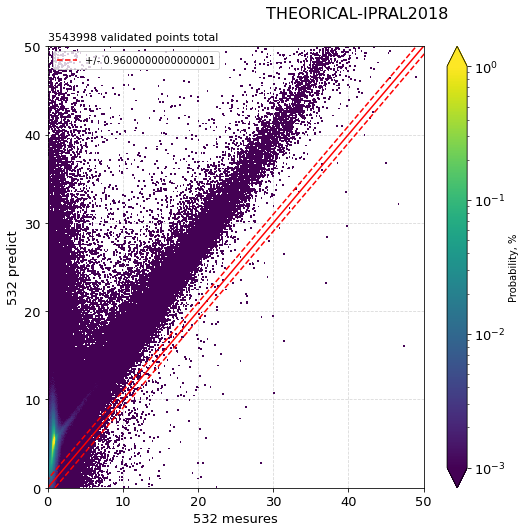

In [70]:
#---------------SR355 

#__init__(self, method_name, dataset_name, closed_units, min_value, max_value, mesures, predictes, 
#         captions, labels, output_path)
params_plot = plots('THEORICAL', dataset_name, np.arange(0.01,1,0.05), 0, 50, all_sr532.values.ravel(), all_sr355.values.ravel()*5.3,
                    f'{(~np.isnan(all_sr532.values[all_sr355.values>0])).sum()} validated points total', ['532 mesures', '532 predict'], ' ')
params_plot.precent_hist2d()

# plt.hist2d(all_sr532.values.ravel(), all_sr355.values.ravel()*5.3, norm=LogNorm(), range=[[0,80], [0,80]], bins=100, density=True)
# plt.colorbar()
# plt.title('all_sr532.values.ravel(), all_sr355.values.ravel()*5.3')


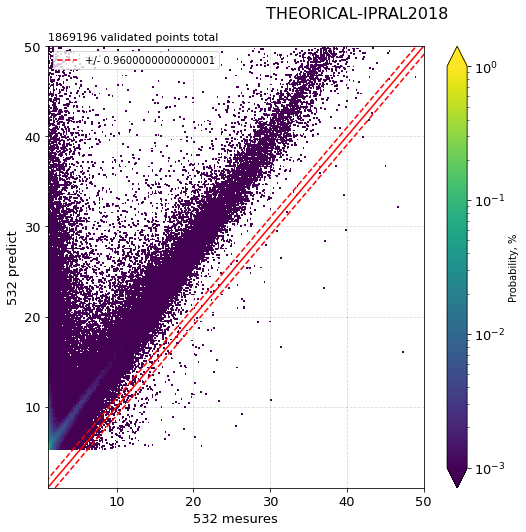

In [71]:
#---------------SR355 > 1
# plt.hist2d(all_sr532.values[all_sr355.values>1], all_sr355.values[all_sr355.values>1]*5.3, norm=LogNorm(), range=[[0,80], [0,80]], bins=100, density=True)
# plt.colorbar()
params_plot = plots('THEORICAL', dataset_name, np.arange(0.01,1,0.05), 1, 50, all_sr532.values[all_sr355.values>1], all_sr355.values[all_sr355.values>1]*5.3,
                   f'{(~np.isnan(all_sr532.values[all_sr355.values>1])).sum()} validated points total', ['532 mesures', '532 predict'], ' ')
params_plot.precent_hist2d()

In [22]:
all_sr355.to_netcdf('/homedata/nmpnguyen/comparaison/IPRAL2020-355-mes_THEORICAL_CONDT-None-None-None.nc')
all_sr532.to_netcdf('/homedata/nmpnguyen/comparaison/IPRAL2020-532-mes_THEORICAL_CONDT-None-None-None.nc')

all_sr532.where(all_sr355 > 1.0, drop=True).to_netcdf('/homedata/nmpnguyen/comparaison/IPRAL2020-532-mes_THEORICAL_CONDT-SR355-1.0-left.nc')
all_sr532.where(all_sr355 < 1.0, drop=True).to_netcdf('/homedata/nmpnguyen/comparaison/IPRAL2020-532-mes_THEORICAL_CONDT-SR355-1.0-right.nc')

all_sr355.where(all_sr355 > 1.0, drop=True).to_netcdf('/homedata/nmpnguyen/comparaison/IPRAL2020-355-mes_THEORICAL_CONDT-SR355-1.0-left.nc')
all_sr355.where(all_sr355 < 1.0, drop=True).to_netcdf('/homedata/nmpnguyen/comparaison/IPRAL2020-355-mes_THEORICAL_CONDT-SR355-1.0-right.nc')

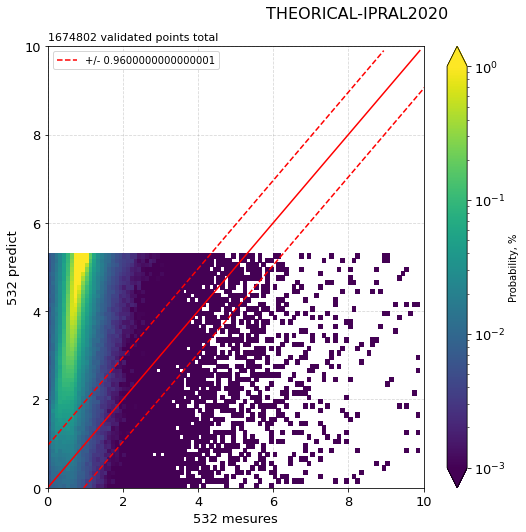

In [72]:
#---------------SR355 < 1
# plt.hist2d(all_sr532.where(all_sr355 < 1.0, drop=True).values.ravel(), all_sr355.where(all_sr355 < 1.0, drop=True).values.ravel()*5.3, norm=LogNorm(), range=[[0,80], [0,80]], bins=100, density=True)
# plt.colorbar()

params_plot = plots('THEORICAL', 'IPRAL2020', np.arange(0.01,1,0.05), 0, 10, all_sr532.values[(all_sr355.values>0)&(all_sr355.values<1)], all_sr355.values[(all_sr355.values>0)&(all_sr355.values<1)]*5.3,
                   f'{(~np.isnan(all_sr532.values[(all_sr355.values>0)&(all_sr355.values<1)])).sum()} validated points total', ['532 mesures', '532 predict'], ' ')
params_plot.precent_hist2d()

### LEARNING METHOD

In [77]:
TEST_dataset = pd.read_pickle(Path('/home/nmpnguyen/conversion_model/comparaison/','ipral_2018-2019-2020_learned_train_dataset.pkl'))
TESTtarget_dataset = pd.read_pickle(Path('/home/nmpnguyen/conversion_model/comparaison/','ipral_2018-2019-2020_learned_traintarget_dataset.pkl'))

Text(0.5, 1.0, 'LEARNING-IPRAL-2018-2019-2020')

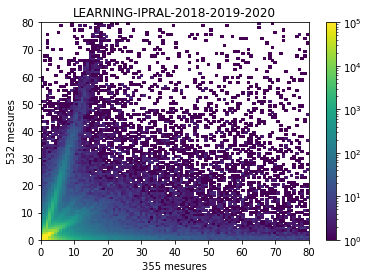

In [79]:
plt.hist2d(TEST_dataset.values[:,0], TESTtarget_dataset.values.ravel(), norm=LogNorm(vmax=1e5), range=[[0,80], [0,80]], bins=100, density=False)
plt.colorbar()
plt.title('testtarget_dataset.values.ravel(), predict_dataset.values.ravel()')
plt.xlabel('355 mesures')
plt.ylabel('532 mesures')
plt.title('LEARNING-IPRAL-2018-2019-2020')

In [71]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(TEST_dataset, TESTtarget_dataset)

DecisionTreeRegressor()

In [73]:
import pickle

with open('/home/nmpnguyen/conversion_model/comparaison/comparaison_model.sav', 'wb') as f:
    pickle.dump(model, f)

In [84]:
test_dataset = pd.read_pickle(Path('/home/nmpnguyen/conversion_model/comparaison/','ipral_2018-2019-2020_learned_train_dataset.pkl'))
testtarget_dataset = pd.read_pickle(Path('/home/nmpnguyen/conversion_model/comparaison/','ipral_2018-2019-2020_learned_traintarget_dataset.pkl'))

# -----------------test_dataset -> prediction where all sr355----------------- 
# predict_dataset = model.predict(test_dataset)
# pd.DataFrame(predict_dataset).to_pickle(Path('/home/nmpnguyen/conversion_model/comparaison/','ipral_2020_learned_TESTpredict_dataset.pkl'))

# -----------------prediction where sr355 < 1.0-----------------
# predict_dataset = model.predict(test_dataset.iloc[np.where((test_dataset['sr355']<1.0) & (test_dataset['sr355']>0))[0]])
# pd.DataFrame(predict_dataset).to_pickle(Path('/home/nmpnguyen/conversion_model/comparaison/','ipral_2020_learned_TESTpredict_dataset_SR355_1.0_left.pkl'))
# testtarget_dataset.iloc[np.where((test_dataset['sr355']<1.0) & (test_dataset['sr355']>0))[0]].to_pickle(Path('/home/nmpnguyen/conversion_model/comparaison/','ipral_2020_learned_TESTtarget_dataset_SR355_1.0_left.pkl'))

# -----------------prediction where sr355 > 1.0-----------------
# predict_dataset = model.predict(test_dataset.iloc[np.where((test_dataset['sr355']>1.0))[0]])
# pd.DataFrame(predict_dataset).to_pickle(Path('/home/nmpnguyen/conversion_model/comparaison/','ipral_2020_learned_TESTpredict_dataset_SR355_1.0_right.pkl'))
# testtarget_dataset.iloc[np.where((test_dataset['sr355']>1.0))[0]].to_pickle(Path('/home/nmpnguyen/conversion_model/comparaison/','ipral_2020_learned_TESTtarget_dataset_SR355_1.0_right.pkl'))

Text(0.5, 1.0, 'LEARNING-IPRAL-2018-2019-2020')

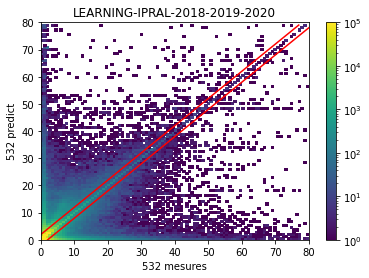

In [87]:
# params_plot = plots('LEARNING', 'IPRAL2020', np.arange(0.01,1,0.05), 0, 50, test_dataset.values[:,0], testtarget_dataset.values.ravel(), 
#                     f'{(~np.isnan(testtarget_dataset.values)).sum()} validated points total', ['355 mesures', '532 mesures'], ' ')
# params_plot.precent_hist2d()

predict_dataset = pd.read_pickle(Path('/home/nmpnguyen/conversion_model/comparaison/', 'ipral_2018-2019-2020_learned_TESTpredict_dataset.pkl'))

plt.hist2d(testtarget_dataset.values.ravel(), predict_dataset.values.ravel(), norm=LogNorm(vmax=1e5), range=[[0,80], [0,80]], bins=100, density=False)
plt.colorbar()
plt.plot(np.arange(0,80,1)+2, np.arange(0,80,1), color='r')
plt.plot(np.arange(0,80,1)-2, np.arange(0,80,1), color='r')
plt.title('testtarget_dataset.values.ravel(), predict_dataset.values.ravel()')
plt.xlabel('532 mesures')
plt.ylabel('532 predict')
plt.title('LEARNING-IPRAL-2018-2019-2020')

In [193]:

# plt.hist2d(testtarget_dataset.values.ravel(), predict_dataset, norm=LogNorm(), range=[[0,50], [0,50]], bins=100, density=True)
# plt.colorbar()
# plt.title('testtarget_dataset.values.ravel(), predict_dataset.values.ravel()')

params_plot = plots('LEARNING', 'IPRAL2020', np.arange(0.01,1,0.05), 0, 50, testtarget_dataset.values.ravel(), test_dataset.values[:,0]*5.3,
                    f'{(~np.isnan(testtarget_dataset.values)).sum()} validated points total', ['532 mesures', '532 predict'], ' ')
params_plot.precent_hist2d()

/net/nfs/tools/python-anaconda/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: The dimension of bins must be equal to the dimension of the  sample x.

### QUANTIFY

In [6]:
method = 'LEARNING'

listfiles = sorted(Path('/home/nmpnguyen/conversion_model/comparaison/').glob(f'ipral_2020-{method}-Stats-between-0.0-40.0*'))
listfiles 
labels = ['where 0 < SR355 < 1', 'where SR355 > 1', 'all SR355'] #
COLORS = ['g', 'r', 'b']

[PosixPath('/home/nmpnguyen/conversion_model/comparaison/ipral_2020-LEARNING-Stats-between-0.0-40.0-1.0-left.pkl'),
 PosixPath('/home/nmpnguyen/conversion_model/comparaison/ipral_2020-LEARNING-Stats-between-0.0-40.0-1.0-right.pkl'),
 PosixPath('/home/nmpnguyen/conversion_model/comparaison/ipral_2020-LEARNING-Stats-between-0.0-40.0-None-None.pkl'),
 PosixPath('/home/nmpnguyen/conversion_model/comparaison/ipral_2020-LEARNING-Stats-between-0.0-40.0.pkl')]

In [58]:
method = 'THEORITICAL'
listfiles = sorted(Path('/homedata/nmpnguyen/comparaison/').glob('IPRAL2018_IPRAL2019_IPRAL2020-THEORITICAL*'))
print(listfiles[0].stem.split('-')[2], len(listfiles))


4.0 16


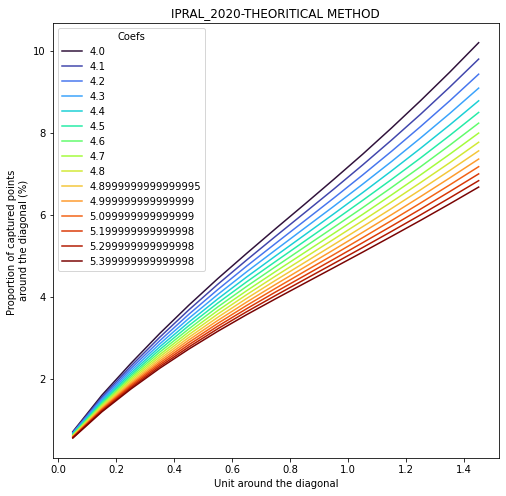

In [60]:
# quantify


fig, ax = plt.subplots(figsize = (8,8))
for filepkl, l in zip(listfiles, range(len(labels))):
    data_pkl = pd.read_pickle(filepkl)
    ax.plot(data_pkl.index, data_pkl.values, label = f'{filepkl.stem.split("-")[2]}') #label = labels[l], color = COLORS[l]

colormap = plt.cm.turbo #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])

ax.legend(loc=2, title = 'Coefs')
ax.set_ylabel('Proportion of captured points \naround the diagonal (%)')
ax.set_xlabel('Unit around the diagonal')
ax.set_title(f'IPRAL_2020-{method} METHOD')
plt.show()

Text(0.5, 1.0, 'IPRAL_2018-2019-2020 LEARNING METHOD')

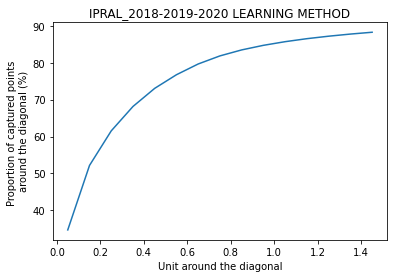

In [91]:
data_pkl = pd.read_pickle(Path('/home/nmpnguyen/conversion_model/comparaison/2018IPRAL2019IPRAL2020-LEARNING-Stats-between-0.0-80.0-None-None.pkl'))

plt.plot(data_pkl.index, data_pkl.values)
plt.ylabel('Proportion of captured points \naround the diagonal (%)')
plt.xlabel('Unit around the diagonal')
plt.title(f'IPRAL_2018-2019-2020 LEARNING METHOD')

In [6]:
class check:
    def __init__(self, min_value: float, max_value: float, closed_unit: float,
                 x_value: float, y_value: float):
        self.x1, self.y1 = min_value-closed_unit, min_value
        self.x2, self.y2 = min_value+closed_unit, min_value
        self.x3, self.y3 = max_value+closed_unit, max_value
        self.x4, self.y4 = max_value-closed_unit, max_value
        self.x, self.y = x_value, y_value
 
    # A function to check whether point P(x, y) lies inside the rectangle
    # formed by A(x1, y1), B(x2, y2), C(x3, y3) and D(x4, y4)
    def check_point(self):
        area = lambda X1, Y1, X2, Y2, X3, Y3 : abs((X1 * (Y2 - Y3) + X2 * (Y3 - Y1) + X3 * (Y1 - Y2)) / 2.0)
        # Calculate area of rectangle ABCD
        A = (area(self.x1, self.y1, self.x2, self.y2, self.x3, self.y3) + 
             area(self.x1, self.y1, self.x4, self.y4, self.x3, self.y3))

        # Calculate area of triangle PAB
        A1 = area(self.x, self.y, self.x1, self.y1, self.x2, self.y2)
    #     print('Aire PAB', A1)

        # Calculate area of triangle PBC
        A2 = area(self.x, self.y, self.x2, self.y2, self.x3, self.y3)
    #     print('Aire PBC', A2)

        # Calculate area of triangle PCD
        A3 = area(self.x, self.y, self.x3, self.y3, self.x4, self.y4)
    #     print('Aire PCD', A3)

        # Calculate area of triangle PAD
        A4 = area(self.x, self.y, self.x1, self.y1, self.x4, self.y4)
    #     print('Aire PAD', A4)

        # Check if sum of A1, A2, A3
        # and A4 is same as A
        # print('Aire PAB + PBC + PCD + PAD', np.round(A1 + A2 + A3 + A4, decimals=2))
        # print('Aire A', np.round(A, decimals=2))
        return (np.round(A, decimals=2) == np.round(A1 + A2 + A3 + A4, decimals=2))

    def quantify(self):
        points_checked = self.check_point()
        proportion_coef = 100*np.where(points_checked == True)[0].shape[0]/points_checked.shape[0]
        return proportion_coef

In [223]:
p = check(0.0, 80.0, 1.0, sr532mes.ravel(),  sr532pred.ravel())
p.quantify()


(array([False, False, False, ..., False, False, False]), 0.07772689425478768)

In [191]:
min_value = 0.0
max_value = 80
F = lambda x,y : check_point(min_value-unit,min_value,
                             min_value+unit,min_value,
                             max_value+unit,max_value,
                             max_value-unit,max_value,x,y)

# check_arr = F(sr532mes.ravel(), sr532pred.ravel())

print(sr532mes.ravel()[4318150], sr532pred.ravel()[4318150], F(sr532mes.ravel()[4318150], sr532pred.ravel()[4318150]))

Aire PAB + PBC + PCD + PAD 240.0
Aire A 240.0
5.382095004110731 5.555232244827853 True


In [181]:
np.where(check_arr==True)[0].shape#, np.where((sr532mes.ravel()<1.5)&(sr532mes.ravel()>0.0)& (sr532pred.ravel()<1.5)& (sr532pred.ravel()>0.0))[0]
# x_edges[0:2], x_edges[-3:-1], y_edges[0], y_edges[-1]

(5210,)

(0.0, 10.0)

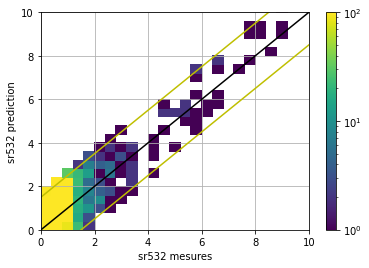

In [165]:
%matplotlib inline
plt.plot(np.arange(0,80), np.arange(0,80), '-k')
plt.hist2d(sr532mes.ravel()[np.where(check_arr==True)[0]], sr532pred.ravel()[np.where(check_arr==True)[0]], 
           bins=200, range=[[0,80], [0,80]], norm=LogNorm(vmax=1e2))
plt.colorbar()
plt.plot(np.arange(0,80)+unit, np.arange(0,80), '-y')
plt.plot(np.arange(0,80)-unit, np.arange(0,80), '-y')
plt.grid()
plt.xlabel('sr532 mesures')
plt.ylabel('sr532 prediction')
plt.ylim(0,10)
plt.xlim(0,10)

In [7]:
def proportion_validated(matrix_measured, matrix_predited, closed_unit, min_value, max_value):
    xedges = yedges = np.arange(min_value, max_value, closed_unit)
    F1 = lambda x,y: check_point(min_value-closed_unit, min_value,
                                 min_value+closed_unit, min_value,
                                 max_value+closed_unit, max_value,
                                 max_value-closed_unit, max_value,
                                 x,y)

    check_points = F1(matrix_measured.ravel(), matrix_predited.ravel())
    propt_valid = 100*np.where(points_valid==True)[0].shape[0]/check_points.shape[0]
    return propt_valid

In [195]:
proportion_validated(sr532mes, sr532pred, unit, 0.0, 80.0)

# np.isin(points_valid, np.where(check_arr==True)[0])#/sr532mes.ravel().shape[0]

Aire PAB + PBC + PCD + PAD [nan nan nan ... nan nan nan]
Aire A 240.0


0.10845129059117402

In [172]:
maindir = '/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/'
pattern = 'ipral_1a_Lz1R15mF30sPbck_v01_*_000000_1440.nc'

dataset355 = get_folder_dataset(maindir, pattern, ipral_characters, 355, True)

dataset355 = set_dataset_with_condition(dataset355, None)

In [224]:
# dataset532 = get_folder_dataset(maindir, pattern, ipral_characters, 532, True)
dataset532mes = pd.read_pickle('/home/nmpnguyen/conversion_model/comparaison/ipral_dataset532mes.pkl')

In [226]:
dataset532mes.shape

(36512, 4000)

## Aerosols extinction coef & backscatter coef

In [8]:
ns = 1.00028571
rho_n = 0.03
#-------------
Na = 6.02e23 #Avodrago
R = 8.31451
P = 101325 #Pa
T = 273.15 + 15 #K
numb_density = (P*Na)/(T*R)*1e-6
Nso = 2.54743e19
#-------------
W = 355e-7
import math
math.pi

3.141592653589793

In [9]:
# Rayleigh backscattering cross section 
print(numb_density, Nso)
cross_section_355 = (24*(math.pi**3))/((W**4)*np.square(Nso)) * np.square((np.square(ns)-1)/(np.square(ns)+2)) * ((6+3*rho_n)/(6-7*rho_n))
print(cross_section_355)

2.5459966024874893e+19 2.54743e+19
2.754917800823278e-26


In [10]:
def molecular_numb_density_profil(P, T):
    # P in Pa, T in K
    Na = 6.02e23
    R = 8.31451
    numb_density = (P)/(T*R)
    return numb_density

In [11]:
# pd_simul = pd.read_pickle('/homedata/nmpnguyen/IPRAL/RF/Simul/ipral_1a_Lz1R15mF30sPbck_v01_20201129_000000_1440_simul.pkl')
# pressure_file = pd_simul['pression']
# tempe_file = pd_simul['ta']

# pressure_file = pressure_file.unstack()
# tempe_file = tempe_file.unstack()

# time = pd_simul.reset_index(inplace=True)['time']
# pd_simul.shape


netcdf_simul = xr.open_dataset('/homedata/nmpnguyen/database_lidars/tmp_simul.nc')
pressure_file = netcdf_simul['pression']
tempe_file = netcdf_simul['ta']

In [12]:
# print(pressure_file, tempe_file)
density_profil = molecular_numb_density_profil(pressure_file, tempe_file)
print(density_profil)

<xarray.DataArray (time: 1201, range: 4000)>
array([[40.26985367, 40.22309693, 40.17628807, ..., -0.11924748,
        -0.11960926, -0.11997108],
       [40.26985367, 40.22309693, 40.17628807, ..., -0.11924748,
        -0.11960926, -0.11997108],
       [40.26985367, 40.22309693, 40.17628807, ..., -0.11924748,
        -0.11960926, -0.11997108],
       ...,
       [40.22238643, 40.13536007, 40.04840777, ..., -0.10441961,
        -0.10473183, -0.10504401],
       [40.22238643, 40.13536007, 40.04840777, ..., -0.10441961,
        -0.10473183, -0.10504401],
       [40.22238643, 40.13536007, 40.04840777, ..., -0.10441961,
        -0.10473183, -0.10504401]])
Coordinates:
  * time     (time) datetime64[ns] 2020-08-05T10:44:31.999999744 ... 2020-08-...
  * range    (range) float64 15.0 30.0 45.0 60.0 ... 5.997e+04 5.998e+04 6e+04


In [13]:
ipraldt = xr.open_dataset(Path('/bdd/SIRTA/pub/basesirta/1a/ipral/2018/10/15/ipral_1a_Lz1R15mF30sPbck_v01_20181015_000000_1440.nc'))
ipraldt

<xarray.Dataset>
Dimensions:                (n_chan: 18, nv: 2, range: 4000, time: 1569)
Coordinates:
  * time                   (time) datetime64[ns] 2018-10-15T10:44:30 ... 2018...
  * range                  (range) float32 15.0 30.0 45.0 ... 5.998e+04 6e+04
Dimensions without coordinates: n_chan, nv
Data variables: (12/73)
    time_bnds              (time, nv) datetime64[ns] ...
    lat                    float32 ...
    lon                    float32 ...
    altitude               float32 ...
    wavelength             (n_chan) float32 ...
    telescope              (n_chan) int32 ...
    ...                     ...
    bckgrd_rcs_16          (time) float64 ...
    rcs_17                 (time, range) float64 ...
    bckgrd_rcs_17          (time) float64 ...
    time_resol             (time) float32 ...
    range_resol            float32 ...
    tilt_angle             float32 ...
Attributes: (12/73)
    system:                          CNRS/IPSL IPRAL RAMAN multiwavelength Lidar
    manufacturers:                   Gordien Strato, Raymetrics, Spectra physics
    overlap_is_corrected:            false
    overlap_function:                false
    site_location:                   Palaiseau, France
    instrument_id:                   IPRAL
    ...                              ...
    telescope0_type:                 Enhanced Cassegrain+Nasmith
    telescope0_manufacturer:         Gordien Strato
    telescope0_model:                special
    telescope1_type:                 Newton
    telescope1_manufacturer:         Gordien Strato
    telescope1_model:                special

In [14]:
channel_Raman = 'rcs_14'
channel_355 = 'rcs_12'
rcs_Raman = (ipraldt[channel_Raman]/np.square(ipraldt['range']) - ipraldt['bckgrd_'+channel_Raman])#*np.square(ipraldt['range'])
rcs_355 = (ipraldt[channel_355]/np.square(ipraldt['range']) - ipraldt['bckgrd_'+channel_355])*np.square(ipraldt['range'])


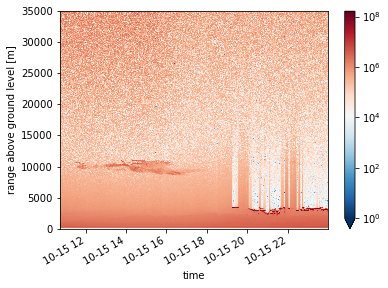

In [16]:
# (ipraldt[channel_355]/np.square(ipraldt['range'])).isel(time=0), ipraldt[channel_355].isel(time=0)


rcs_355.plot(x='time', y='range', norm=LogNorm(vmin=1e0), ylim=(0, 35000))

In [32]:
rcs_355.sel(range = ipraldt.range[400:405]).mean(dim='range'), ipraldt.range[400:405]


(<xarray.DataArray (time: 1569)>
 array([ 4.53440878e+05,  5.03149246e+05,  5.33633324e+05, ...,
        -1.47717088e+04,  4.97073005e+02, -8.45179900e+03])
 Coordinates:
   * time     (time) datetime64[ns] 2018-10-15T10:44:30 ... 2018-10-15T23:59:14,
 <xarray.DataArray 'range' (range: 5)>
 array([6015., 6030., 6045., 6060., 6075.], dtype=float32)
 Coordinates:
   * range    (range) float32 6.015e+03 6.03e+03 6.045e+03 6.06e+03 6.075e+03
 Attributes:
     long_name:  range above ground level
     units:      m)

In [303]:
density_profil

<xarray.DataArray (time: 1201, range: 4000)>
array([[40.26985367, 40.22309693, 40.17628807, ..., -0.11924748,
        -0.11960926, -0.11997108],
       [40.26985367, 40.22309693, 40.17628807, ..., -0.11924748,
        -0.11960926, -0.11997108],
       [40.26985367, 40.22309693, 40.17628807, ..., -0.11924748,
        -0.11960926, -0.11997108],
       ...,
       [40.22238643, 40.13536007, 40.04840777, ..., -0.10441961,
        -0.10473183, -0.10504401],
       [40.22238643, 40.13536007, 40.04840777, ..., -0.10441961,
        -0.10473183, -0.10504401],
       [40.22238643, 40.13536007, 40.04840777, ..., -0.10441961,
        -0.10473183, -0.10504401]])
Coordinates:
  * time     (time) datetime64[ns] 2020-08-05T10:44:31.999999744 ... 2020-08-...
  * range    (range) float64 15.0 30.0 45.0 60.0 ... 5.997e+04 5.998e+04 6e+04

In [326]:
def extinction_aerosol(alt, n, rcs_raman, ext_mol_355, ext_mol_raman):
    wavelength = 355
    wavelength_raman = 387 
    derive = np.zeros_like(n)
    ext_aer_355 = np.zeros_like(n)
    print('Shape of derive and ext_aer', derive.shape, ext_aer_355.shape)
    for z in range(len(alt)-1):
        derive[:, z] = (-n[:,z+1]/rcs_raman[:, z+1] + n[:,z]/rcs_raman[:, z])/(alt[z+1] - alt[z])
        ext_aer_355[:, z] = (derive[:, z] - ext_mol_355[:, z] - ext_mol_raman[:, z])/(1 + 355/387)
    print(derive)
    return ext_aer_355

def backscatter_aerosol(SR, n, cross_section_Ray):
    R = SR - 1
    bcs_aer = R*n*cross_section_Ray
    return bcs_aer

In [305]:
print(ipraldt['range'][1], density_profil.shape)
alpha_aer_355 = extinction_aerosol(ipraldt['range'].values, density_profil, (rcs_Raman*np.square(ipraldt['range'])).values, 
                                      netcdf_simul['alpha355'], netcdf_simul['alpha387'])

<xarray.DataArray 'range' ()>
array(30., dtype=float32)
Coordinates:
    range    float32 30.0
Attributes:
    long_name:  range above ground level
    units:      m (1201, 4000)
Shape of derive and ext_aer (1201, 4000) (1201, 4000)
[[ 3.46968933e+00  3.41030688e-01  9.96598160e-01 ...  6.33320899e-09
  -1.94267265e-08  0.00000000e+00]
 [ 2.35019102e+00  5.90428077e-01  1.09349965e+00 ... -6.74104948e-09
   1.40129289e-09  0.00000000e+00]
 [ 2.97172817e+00  2.95645607e-01  6.34469720e-01 ...  2.00417306e-07
  -1.96645773e-07  0.00000000e+00]
 ...
 [ 2.54262102e+00  5.34241532e-01  2.01564346e-01 ...  1.70241731e-08
   2.43134651e-10  0.00000000e+00]
 [ 2.89315893e+00  7.28501294e-01  2.24761954e-01 ...  1.28706902e-09
   4.39324539e-09  0.00000000e+00]
 [ 2.77503014e+00  6.34656677e-01  2.45801453e-01 ...  9.93549489e-09
  -1.04807740e-09  0.00000000e+00]]


In [310]:
A = density_profil/rcs_Raman
a = np.zeros_like(A)
for t in range(A.shape[1]-1):
    a[:, t] = (A[:, t+1] - A[:, t])/(ipraldt['range'][t+1] - ipraldt['range'][t])*1/A[:,t]

In [313]:
alpha_aer_355 = (a - netcdf_simul['alpha355']- netcdf_simul['alpha387'])/(1 + 355/387)

<ipython-input-324-3f678479f6af>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ipraldt['time'].values, ipraldt['range'].values, alpha_aer_355.T, norm=LogNorm(), shading='flat')


(0.0, 20000.0)

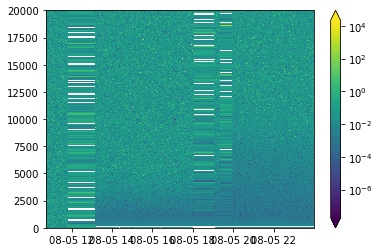

In [324]:
# plt.plot(alpha_aer_355[100,:], ipraldt['range'].values)
# plt.ylim(0,8000)

plt.pcolormesh(ipraldt['time'].values, ipraldt['range'].values, alpha_aer_355.T, norm=LogNorm(), shading='flat')
plt.colorbar(extend = 'both')
plt.ylim(0, 20000)

In [341]:
maindir = '/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/'
pattern = 'ipral_1a_Lz1R15mF30sPbck_v01_20200805_000000_1440.nc'


dt = xr.open_dataset(Path(maindir, pattern))
print(dt['time'])
# (dt['calibrated']/dt['simulated'] - 1)*density_profil*6.02e23*cross_section_355
bcs_aer_355 = backscatter_aerosol((dt['calibrated']/dt['simulated']).sel(wavelength=355), density_profil*6.02e23, cross_section_355)

<xarray.DataArray 'time' (time: 1201)>
array(['2020-08-05T10:44:31.999999744', '2020-08-05T10:45:03.000000256',
       '2020-08-05T10:45:33.000000000', ..., '2020-08-05T23:58:23.000000000',
       '2020-08-05T23:58:53.000000000', '2020-08-05T23:59:24.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-08-05T10:44:31.999999744 ... 2020-08-...


In [349]:
bcs_aer_355[:,:1333]#.plot(x='time', y='range', ylim=(0, 20000),cmap='turbo', vmin=-10, vmax=0)

<xarray.DataArray (time: 1201, range: 1333)>
array([[-0.66785935, -0.66708304, -0.66620887, ..., -0.41638328,
        -0.73058208,  0.29159428],
       [-0.66785927, -0.66708266, -0.66621368, ..., -0.09906457,
        -0.54356805, -0.36844621],
       [-0.6678594 , -0.66708324, -0.66621486, ...,  0.17421583,
        -0.0356195 ,  0.43636738],
       ...,
       [-0.66707138, -0.66562465, -0.664059  , ...,  0.45190175,
         0.84642444,  1.12914706],
       [-0.66707141, -0.66562534, -0.66406209, ...,  0.14956023,
        -0.32150887,  0.28302387],
       [-0.66707142, -0.66562477, -0.66406791, ..., -0.41943742,
         0.80601772, -0.167447  ]])
Coordinates:
  * time        (time) datetime64[ns] 2020-08-05T10:44:31.999999744 ... 2020-...
  * range       (range) float32 15.0 30.0 45.0 ... 1.996e+04 1.998e+04 2e+04
    wavelength  int64 355